In [54]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns
import random
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [55]:
def seed_all(seed_value=42):
    
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value) 
    print(f"Seeding complete. All libraries are now set to seed: {seed_value}")
    
seed_all()

Seeding complete. All libraries are now set to seed: 42


## Define the label column 'Direction' as Close(t) > (Close t-5)

In [56]:
df = pd.read_excel('/kaggle/input/s-and-p-500-index-dataset/SP 500 Index Dataset.xlsx', sheet_name='SP500 Data')
df['Direction'] = (df['Close'].shift(-5) > df['Close']).astype(int)
df = df.dropna()

In [57]:
value_counts = df['Direction'].value_counts().sort_index()
print(value_counts)

Direction
0    3800
1    5193
Name: count, dtype: int64


## Stationarity check and STL-decomposition of the series

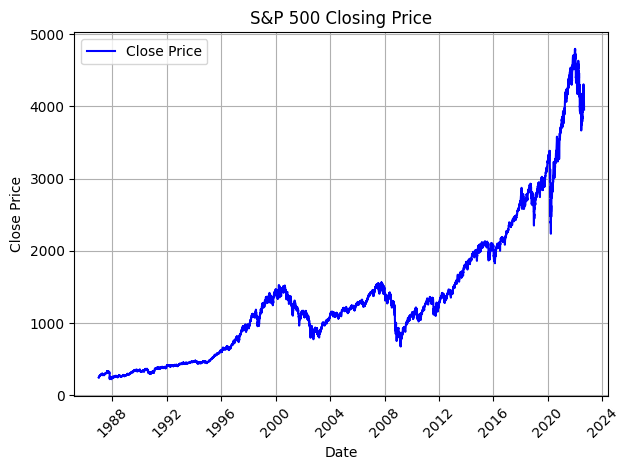

In [58]:
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('S&P 500 Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

ADF Statistic: -16.552217307439598
p-value: 1.9404826147752285e-29
Critical Values:
   1%: -3.431080367939319
   5%: -2.8618627750396257
   10%: -2.566941808133596
Reject the null hypothesis: The time series is stationary.


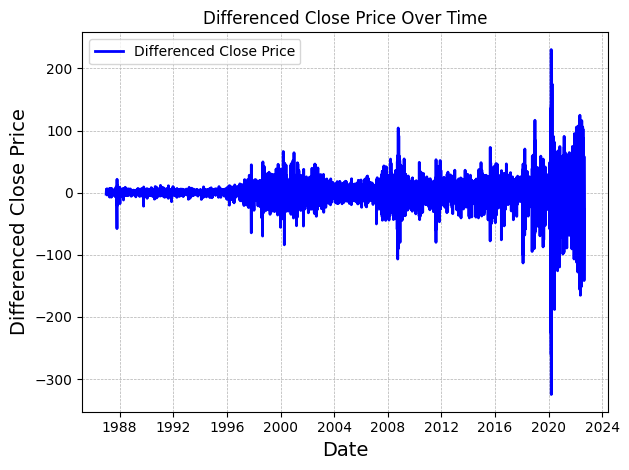

In [60]:
df['Close_diff'] = df['Close'].diff()
df = df.dropna()
df = df.drop('Close', axis=1)
df.reset_index(drop=True, inplace=True)
series = df['Close_diff']

result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret the result
if result[1] < 0.05:
    print("Reject the null hypothesis: The time series is stationary.")
else:
    print("Fail to reject the null hypothesis: The time series is non-stationary.")

plt.plot(df['Date'], df['Close_diff'], color='blue', label='Differenced Close Price', linewidth=2)
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Close Price', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
features = [
    "Open","High","Low","Close_diff","Volume",
    "p_sma_5","p_sma_10","p_sma_20","p_sma_50","p_sma_100","p_sma_200",
    "p_ema_5","p_ema_10","p_ema_20","p_ema_50","p_ema_100","p_ema_200",
    "v_sma_5","v_sma_10","v_sma_20","v_sma_50","v_sma_100","v_sma_200",
    "obv","obv_sma_5","obv_sma_10","obv_sma_20","obv_sma_50","obv_sma_100","obv_sma_200",
    "adi","adi_sma_5","adi_sma_10","adi_sma_20","adi_sma_50","adi_sma_100","adi_sma_200",
    "cmf","mfi","em_1","em_14",
    "vpt","vpt_sma_5","vpt_sma_10","vpt_sma_20","vpt_sma_50","vpt_sma_100","vpt_sma_200",
    "nvi","nvi_ema_5","nvi_ema_10","nvi_ema_20","nvi_ema_50","nvi_ema_100","nvi_ema_200",
    "vwap_5","vwap_10","vwap_20","vwap_50","vwap_100","vwap_200",
    "atr","atr_sma_5","atr_sma_10","atr_sma_20","atr_sma_50","atr_sma_100","atr_sma_200",
    "bbh","bbl","bbm","bbp","bbw",
    "kch","kcl","kcc","kcp","kcw",
    "dch","dcl","dcm","dcp","dcw",
    "macd","macd_signal","macd_diff",
    "adx","adx_pos","adx_neg","cci",
    "vortex_ind_pos","vortex_ind_neg","vortex_ind_diff",
    "trix","trix_signal","trix_diff",
    "mass_index",
    "kst","kst_sig","kst_diff",
    "aroon_up","aroon_down","aroon_ind",
    "stc","swi","swi_accum","rsi",
    "stoch_rsi","stoch_rsi_k","stoch_rsi_d","stoch","stoch_signal",
    "tsi","tsi_signal","uo","wr","ao",
    "roc_21","roc_63","roc_125","roc_250",
    "ppo","ppo_signal","ppo_hist",
    "pvo","pvo_signal","pvo_hist",
    "cmo","cmo_signal",
    "dmi",
    "ko","ko_signal",
    "smi","smi_signal"
]

In [69]:
x 
x = df[features].values
x = StandardScaler().fit_transform(x)
y = df[['Direction']]

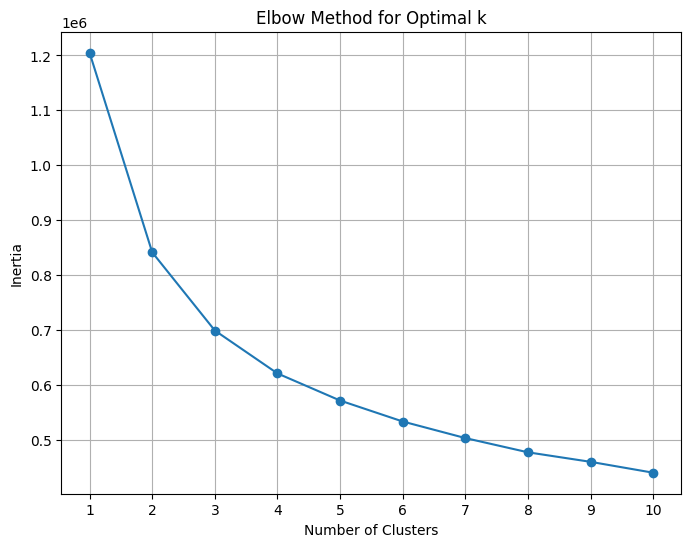

In [65]:
inertia = []
cluster_range = range(1, 11)  # Testing cluster numbers from 1 to 10

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

# Create the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid()
plt.show()

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(x)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
principal_df['Direction'] = y
principal_df

,PC1,PC2,PC3,Direction
0,-8.338788,5.048936,-3.749512,1
1,-8.357429,5.778137,-3.794168,1
2,-8.375681,6.798393,-3.928856,1
3,-8.260327,3.759788,-1.891192,1
4,-8.091677,-0.514380,0.537772,1
...,...,...,...,...
8987,22.481078,-0.773578,-4.942645,0
8988,22.405434,4.273119,-7.453988,0
8989,22.230309,5.693066,-6.921069,0
8990,22.098524,8.244608,-6.751821,0


In [77]:
X = principal_df[['PC1', 'PC2', 'PC3']]
y = principal_df['Direction']

tscv = TimeSeriesSplit(n_splits=5)

accuracies = []
confusion_matrices = []
reports = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_pred))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    reports.append(classification_report(y_test, y_pred, output_dict=True))

average_accuracy = sum(accuracies) / len(accuracies)
print('Average Accuracy:', average_accuracy)

Average Accuracy: 0.4959946595460615
